In [1]:
import yfinance as yf 
import torch 
import torch.nn as nn 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import MinMaxScaler 

data = yf.download('MANALIPETC.NS', start='2020-01-01', end='2024-01-01') 
data = data['Close'].values.reshape(-1,1) 
scaler = MinMaxScaler(feature_range=(0,1)) 
data_normalized = scaler.fit_transform(data) 
sequence_length = 30 
train_size = int(len(data_normalized) * 0.8) 
input_size = 1 
hidden_size = 50 
output_size = 1 
num_epochs = 100 
learning_rate = 0.001 
memory_size = 20 
memory_dim = 50 

def  create_sequences(data,seq_length):
    x = [] 
    y = [] 
    for i in range(len(data) - seq_length - 1):
        _x = data[i:(i + seq_length)] 
        _y = data[i + seq_length] 
        x.append(_x) 
        y.append(_y) 
    return np.array(x),np.array(y)

[*********************100%***********************]  1 of 1 completed


In [2]:
x,y = create_sequences(data_normalized,sequence_length) 
x_train,x_test = x[:train_size],x[train_size:] 
y_train,y_test = y[:train_size],y[train_size:] 

x_train = torch.tensor(x_train,dtype=torch.float32) 
y_train = torch.tensor(y_train,dtype=torch.float32) 
x_test = torch.tensor(x_test,dtype=torch.float32) 
y_test = torch.tensor(y_test,dtype=torch.float32) 

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        c_0 = torch.zeros(1, x.size(0), hidden_size).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out
class MANNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, memory_size, memory_dim):
        super(MANNModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.memory = nn.Parameter(torch.zeros(memory_size, memory_dim), requires_grad=True)  # Memory as a learnable parameter
        self.fc_memory = nn.Linear(hidden_size + memory_dim, output_size)
        self.fc_write = nn.Linear(hidden_size, memory_dim)
    def forward(self,x):
        h_0 = torch.zeros(1,x.size(0),hidden_size).to(x.device) 
        c_0 = torch.zeros(1,x.size(0),hidden_size).to(x.device) 
        out,_ = self.lstm(x,(h_0,c_0)) 
        memory_weights = torch.softmax(out[:, -1, :].matmul(self.memory.t()),dim=1) 
        memory_read = memory_weights.matmul(self.memory) 
        combined = torch.cat((out[:, -1, :],memory_read),dim=1) 
        output = self.fc_memory(combined) 
        memory_write = torch.tanh(self.fc_write(out[:, -1, :])) 
        write_weights = torch.softmax(out[:, -1, :].matmul(self.memory.t()),dim=1) 
        write_weights = write_weights.mean(dim=0).unsqueeze(-1) 
        self.memory = nn.Parameter((1 - write_weights) * self.memory + write_weights * memory_write.mean(dim=0).unsqueeze(0),requires_grad=True) 
        return output
lstm_model = LSTMModel(input_size,hidden_size,output_size).to('cpu') 
mann_model = MANNModel(input_size,hidden_size,output_size,memory_size,memory_dim).to('cpu') 
criterion = nn.MSELoss() 
optimizer_lstm = torch.optim.Adam(lstm_model.parameters(),lr=learning_rate) 
optimizer_mann = torch.optim.Adam(mann_model.parameters(),lr=learning_rate) 
def train_model(model,optimizer,x_train,y_train,num_epochs):
    model.train() 
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(x_train) 
        loss = criterion(outputs,y_train) 
        loss.backward() 
        optimizer.step() 
        if (epoch + 1) % 20 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Training LSTM Model...")

Training LSTM Model...


In [4]:
train_model(lstm_model,optimizer_lstm,x_train,y_train,num_epochs) 
print("Training MANN Model...")
train_model(mann_model, optimizer_mann, x_train, y_train, num_epochs)


Epoch [20/100], Loss: 0.0738
Epoch [40/100], Loss: 0.0358
Epoch [60/100], Loss: 0.0127
Epoch [80/100], Loss: 0.0052
Epoch [100/100], Loss: 0.0033
Training MANN Model...
Epoch [20/100], Loss: 0.0741
Epoch [40/100], Loss: 0.0431
Epoch [60/100], Loss: 0.0155
Epoch [80/100], Loss: 0.0058
Epoch [100/100], Loss: 0.0028


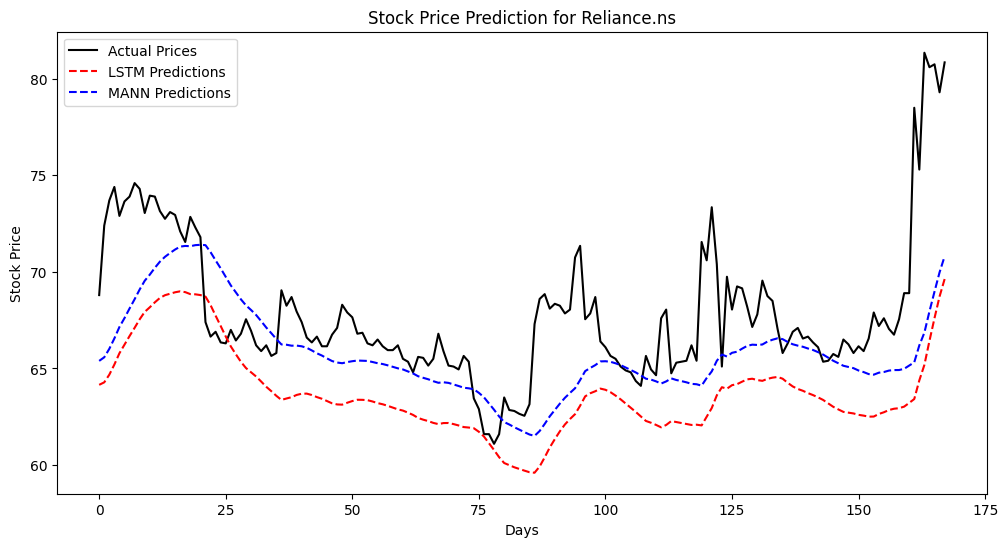

In [5]:
def predict(model,x):
    model.eval() 
    with torch.no_grad():
        return model(x).cpu().numpy() 
y_pred_lstm = predict(lstm_model,x_test) 
y_pred_mann = predict(mann_model,x_test) 
y_test_actual = scaler.inverse_transform(y_test) 
y_pred_lstm_actual = scaler.inverse_transform(y_pred_lstm) 
y_pred_mann_actual = scaler.inverse_transform(y_pred_mann) 
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices', color='black')
plt.plot(y_pred_lstm_actual, label='LSTM Predictions', color='red', linestyle='--')
plt.plot(y_pred_mann_actual, label='MANN Predictions', color='blue', linestyle='--')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction for Reliance.ns')
plt.legend()
plt.show()

In [6]:
def calculate_mae_mape(actual,predicted):
    mae = np.mean(np.abs(actual - predicted)) 
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100 
    return mae,mape 

mae_lstm,mape_lstm = calculate_mae_mape(y_test_actual,y_pred_lstm_actual)
print(f"LSTM Model - MAE: {mae_lstm:.4f}, MAPE: {mape_lstm:.2f}%")

# Compute MAE and MAPE for MANN
mae_mann, mape_mann = calculate_mae_mape(y_test_actual, y_pred_mann_actual)
print(f"MANN Model - MAE: {mae_mann:.4f}, MAPE: {mape_mann:.2f}%") 


LSTM Model - MAE: 4.1643, MAPE: 5.98%
MANN Model - MAE: 2.5569, MAPE: 3.62%
